In [2]:
%config IPCompleter.greedy=True

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
import glob

In [3]:
def load_data(path):
    with open(path) as f:
        data = json.load(f)
        return data
    
def load_data_from_dir(path):
    files = glob.glob(path)
    data_preproc_torch = { 'epoch': [], 'reward': [], 'workers': [] }
    for file in files:
        tmp_data = load_data(file)
        for i in range(len(tmp_data['epoch'])):
            data_preproc_torch['epoch'].append(tmp_data['epoch'][i])
            data_preproc_torch['reward'].append(tmp_data['mean_reward'][i])
        data_preproc_torch['workers'].extend([tmp_data['workers']] * len(tmp_data['epoch']))
    df = pd.DataFrame(data=data_preproc_torch)
    df_wide = df.pivot('epoch', 'workers', 'reward')
    return df_wide

In [16]:
results_wide = load_data_from_dir('../results/torch/Run2/*.json')

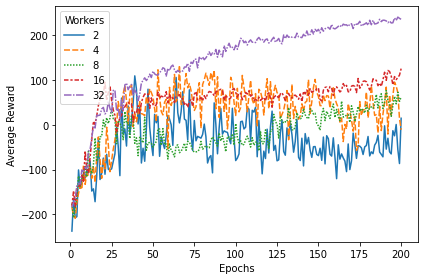

In [18]:
ax = sns.lineplot(data=results_wide)
ax.legend(title='Workers')
ax.set(xlabel='Epochs', ylabel='Average Reward')
plt.tight_layout()
plt.show()
ax.get_figure().savefig('torch_worker_results.png', dpi=400)